# EDA

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import probplot

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.preprocessing import StandardScaler

from IPython.display import display
pd.options.display.max_columns = 500

In [152]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [153]:
# remove outliers
train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]
train = train[~((train['MasVnrArea'] > 1400) & (train['SalePrice'] < 300000))]
train = train[~((train['LotFrontage'] > 300) & (train['SalePrice'] < 300000 ))]
train = train[~((train['LotArea'] > 200000) & (train['SalePrice'] < 500000 ))]
# train = train[~((train['YearBuilt'] < 1900) & (train['SalePrice'] > 400000))]
train = train[~((train['OpenPorchSF'] > 500) & (train['SalePrice'] < 100000))]


In [149]:
response_variable = np.log1p(train.SalePrice)
id_ = test.Id
train = train.loc[:,'MSSubClass':'SaleCondition']
test = test.loc[:,'MSSubClass':'SaleCondition']

train['SalePrice'] = response_variable

In [140]:
# train.drop(['1stFlrSF','GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)
# test.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd'], axis=1, inplace=True)

In [141]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

numeric_feats = train.nunique() > 70
numeric_feats = train.T[numeric_feats].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))

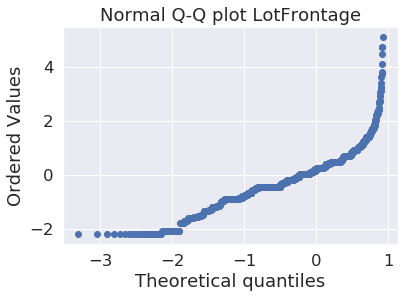

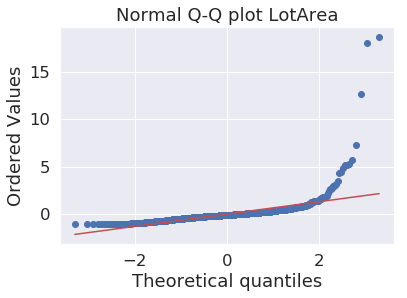

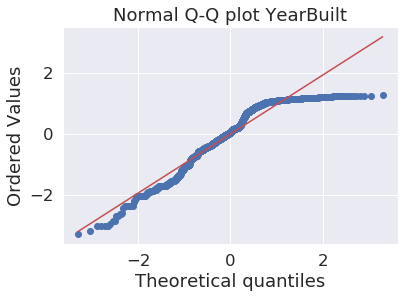

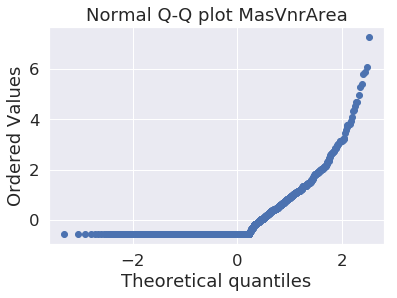

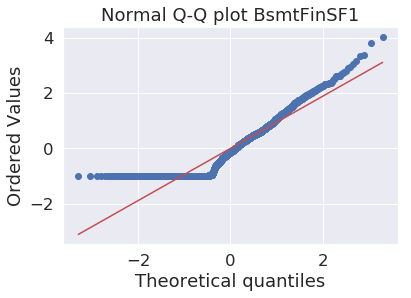

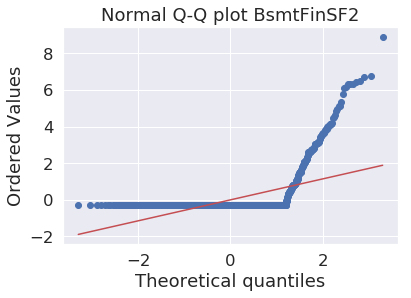

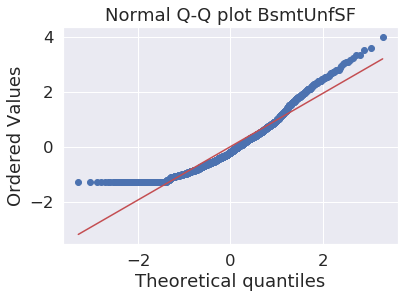

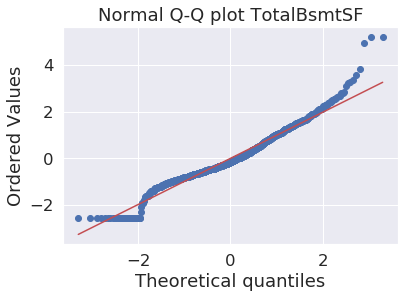

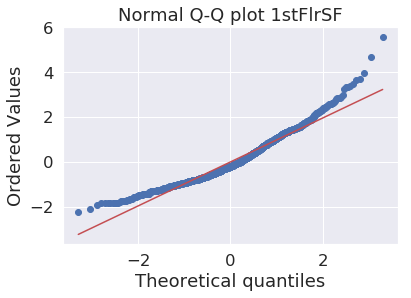

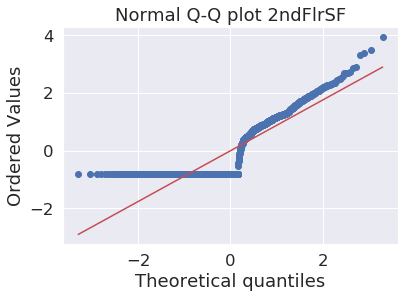

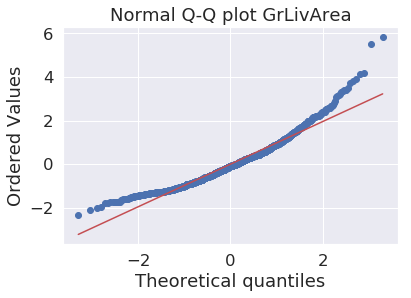

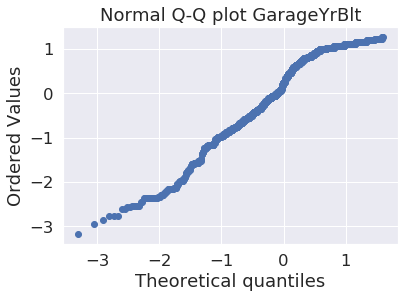

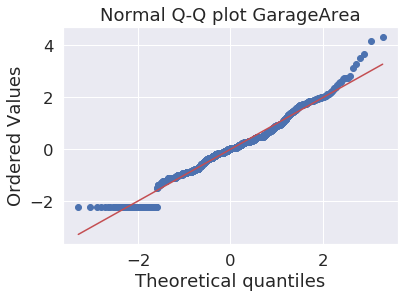

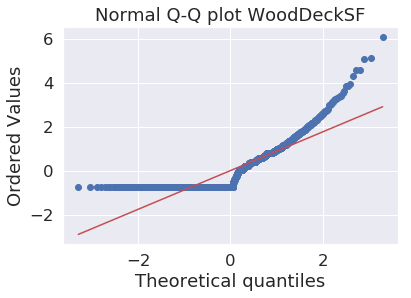

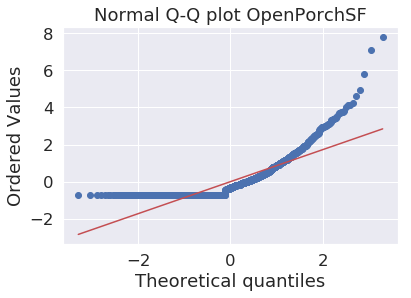

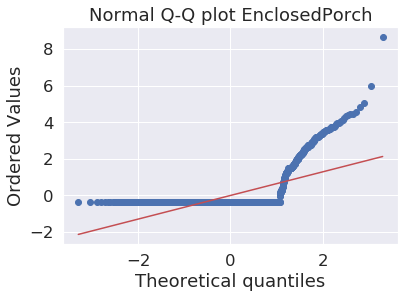

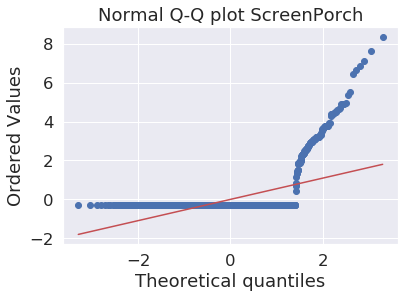

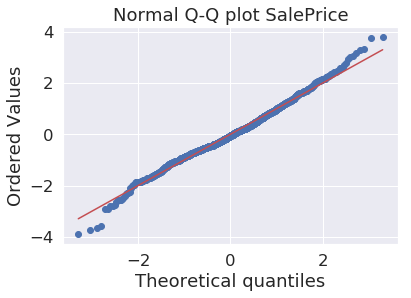

In [115]:
import scipy.stats as stats

for col in numeric_feats:
    obs = train[col]

    z = (obs-np.mean(obs))/np.std(obs)

    stats.probplot(z, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot "+ col)
    plt.show()

In [116]:
# for col in numeric_feats:
#     plt.figure(figsize=(40,20))
#     plt.hist(train[col].fillna(train[col].mean()))
#     plt.xlabel(col, fontsize=40)
#     plt.ylabel('Count', fontsize=40)
#     plt.yticks(fontsize=30)
#     plt.xticks(fontsize=30)
#     plt.title(col + ' Histogram', fontsize=40)
#     plt.show()


In [117]:
# skewed_feats

LotFrontage       0.674842
LotArea          10.940801
YearBuilt        -0.613173
MasVnrArea        2.472857
BsmtFinSF1        0.766455
BsmtFinSF2        4.276118
BsmtUnfSF         0.916497
TotalBsmtSF       0.505177
1stFlrSF          0.886085
2ndFlrSF          0.811363
GrLivArea         1.017706
GarageYrBlt      -0.648798
GarageArea        0.136779
WoodDeckSF        1.540658
OpenPorchSF       2.201316
EnclosedPorch     3.086928
ScreenPorch       4.136607
SalePrice         0.158900
dtype: float64

In [142]:
skewed_feats = skewed_feats[skewed_feats > .65]
skewed_index = skewed_feats.index


# for col in skewed_index:
#     train[col] = power_transform(train[[col]].replace(0,1), method='box-cox', standardize=False)

# for col in skewed_index:
#     test[col] = power_transform(test[[col]].replace(0,1), method='box-cox', standardize=False)

#train[skewed_index] = train[skewed_index].replace(0,1)
#test[skewed_index] = test[skewed_index].replace(0,1)

train[skewed_index] = boxcox1p(train[skewed_index], 0.1)
test[skewed_index] = boxcox1p(test[skewed_index], 0.1)

# ss = StandardScaler()
# train[skewed_index] = ss.fit_transform(train[skewed_index])
# test[skewed_index] = ss.transform(test[skewed_index])

In [119]:
# train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

LotFrontage     -0.677385
LotArea          0.421155
YearBuilt       -0.613173
MasVnrArea       0.592144
BsmtFinSF1      -0.496208
BsmtFinSF2       2.622903
BsmtUnfSF       -1.555962
TotalBsmtSF      0.505177
1stFlrSF         0.135031
2ndFlrSF         0.311516
GrLivArea        0.088827
GarageYrBlt     -0.648798
GarageArea       0.136779
WoodDeckSF       0.214639
OpenPorchSF      0.108631
EnclosedPorch    2.162527
ScreenPorch      3.194346
SalePrice        0.158900
dtype: float64

In [120]:
# for col in numeric_feats:
#     plt.figure(figsize=(40,20))
#     plt.hist(train[col].fillna(train[col].mean()))
#     plt.xlabel(col, fontsize=40)
#     plt.ylabel('Count', fontsize=40)
#     plt.yticks(fontsize=30)
#     plt.xticks(fontsize=30)
#     plt.title(col + ' Histogram', fontsize=40)
#     plt.show()


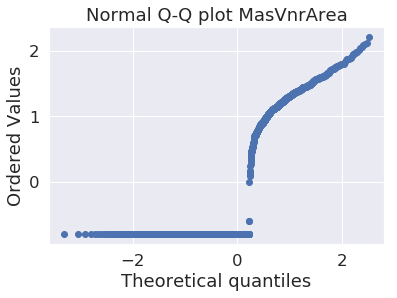

In [145]:
obs = train['MasVnrArea']

z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot "+ 'MasVnrArea')
plt.show()

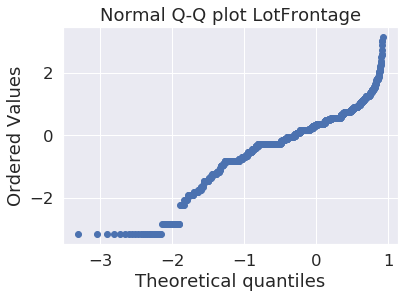

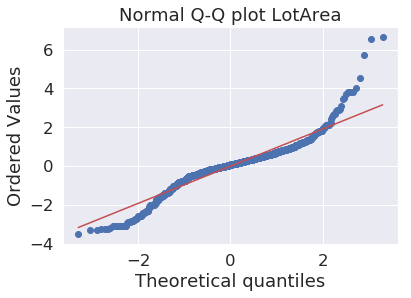

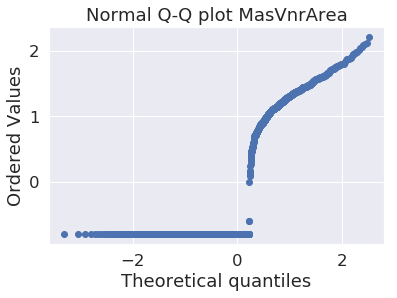

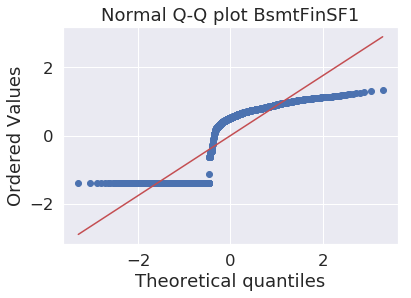

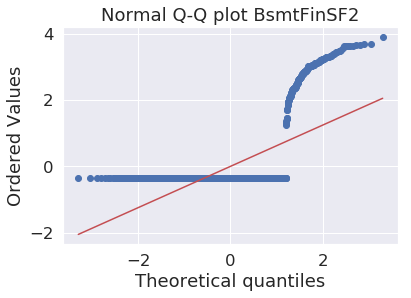

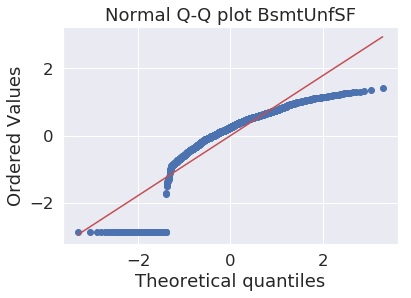

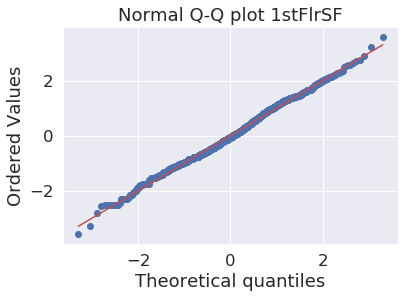

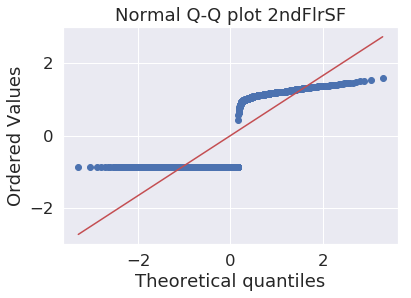

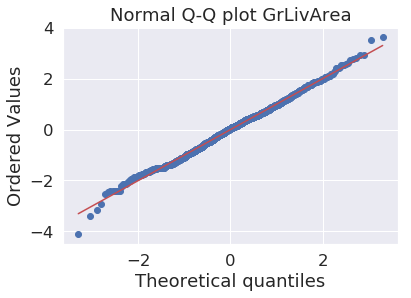

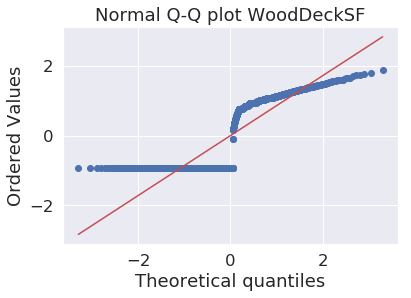

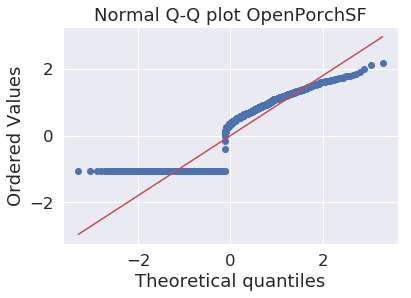

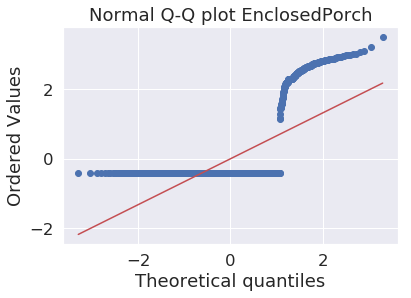

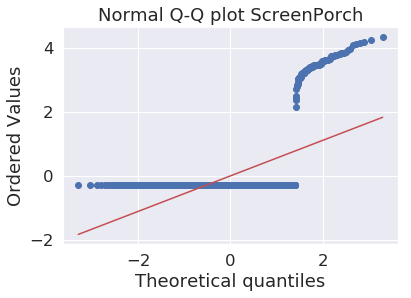

In [143]:
import scipy.stats as stats

for col in skewed_index:
    obs = train[col]

    z = (obs-np.mean(obs))/np.std(obs)

    stats.probplot(z, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot "+ col)
    plt.show()

## Correlation

Text(0.5,1,'Correlation HeatMap')

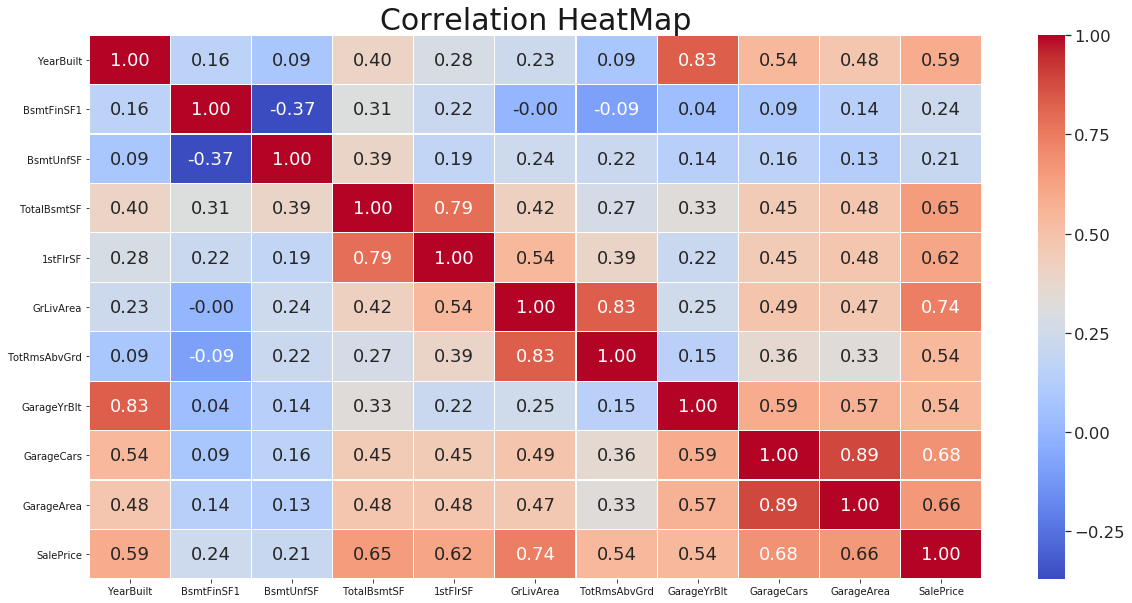

In [39]:
zoomin = train[['YearBuilt', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd','ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF','GrLivArea', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SalePrice']]
f, ax = plt.subplots(figsize=(20, 10))
corr = zoomin.corr()
sns.set(font_scale=1.5)
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.1)
ax.set_title('Correlation HeatMap', fontsize=30) 

# Multicollinearity VIF

In [154]:
train = train.rename({'1stFlrSF':'FirstFloorSF', 'Exterior2nd_Wd Sdng': 'ExteriorS', 'Exterior2nd_Wd Shng': 'ExteriorSnd', 'HouseStyle_2.5Fin': 'HouseStyle_S', '3SsnPorch':'threesnpo','HouseStyle_2.5Unf': 'HouseStylUNf2', 'Exterior2nd_Brk Cmn':'Exterior2nd_Brk', '2ndFlrSF':'ndFlrSF', 'HouseStyle_1.5Unf':'HouseStyle_unf', 'HouseStyle_1.5Fin':'HouseStyle_fin', 'RoofMatl_Tar&Grv':'RoofMatl_Tarand', 'MSZoning_C (all)':'MSZoning_Call', 'Exterior1st_Wd Sdng': 'ExteriorFst'}, axis='columns')

features = "+".join(train.columns.drop(['SalePrice']))

y, X = dmatrices('SalePrice ~' + features, train, return_type='dataframe')

vif = pd.DataFrame(index = X.columns)
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
pltme = vif.query('VIF > 5 & VIF < 1000000000')
pltme.VIF.sort_values(ascending=False) 

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(vif.sort_values('VIF Factor', ascending=False).iloc[165:,].columns,)

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title('VIF Factors > 5')
plt.ylabel('VIF')
plt.bar(pltme.VIF.sort_values(ascending=False).index[4:], pltme.VIF.sort_values(ascending=False)[4:])